In [4]:
'''Setup'''
import os
import sys
import cv2
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import datetime
import PIL
import ast
sys.path.append("/mnt/vstor/CSE_MSE_RXF131/cradle-members/mds3/aml334/mds3-advman-2/topics/aml-fractography/fractography_scripts")
import organize_data
combined_df = pd.read_csv('/mnt/vstor/CSE_MSE_RXF131/lab-staging/mds3/AdvManu/fractography/combined_df.csv')

organize_data


In [5]:
points_df = combined_df[~combined_df['points'].isna()]
points_df['image_class'].value_counts()
points_df['sample_id'].value_counts().head(10)

sample_id
NASA1-83-3    42
EP7-82-2      42
EP7-81-1      22
EP5-71-1      20
EPO4-81-1     16
EP4-24-1      15
EP5-84-1      12
NASA1-83-1    12
CMU1-13-1     10
EP5-72-2      10
Name: count, dtype: int64

In [3]:
STOP=10
i=0
for group_string, group in points_df.groupby("sample_id"):
    if STOP>i:
        imgs = group['image_path'].apply(cv2.imread)
        points_list = group['points'].apply(ast.literal_eval)
        points_polygons = points_list.apply(lambda x: np.array(x,dtype=np.int32))
        masks = []
        for i in range(len(imgs)-1):
            mask = np.zeros_like(imgs[i].shape[:2],dtype=np.uint8)
            cv2.fillPoly(
                mask,
                [points_polygons[i]],
                255
            )
            masks.append(mask)
    i+=1
    print(i)

KeyError: 3

In [4]:
points_df = combined_df[~combined_df['points'].isna()]

STOP = 11

def process_mask(mask):
    # Find connected components
    num_labels, labels = cv2.connectedComponents(mask)
    
    # Count components (excluding background)
    num_objects = num_labels - 1
    
    # Find largest object
    largest_object_mask = np.zeros_like(mask)
    if num_objects > 0:
        # Get unique labels, excluding background (0)
        label_counts = [np.sum(labels == i) for i in range(1, num_labels)]
        largest_object_label = np.argmax(label_counts) + 1
        largest_object_mask = (labels == largest_object_label).astype(np.uint8) * 255
    
    return num_objects, largest_object_mask


def extract_largest_object(img,points_list):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(
        mask,
        [np.array(points_list, dtype=np.int32)],
        255
    )
    img_object, largest_object_mask = process_mask(mask)
    return largest_object_mask

def find_sharpness(numpy_array):
    #Convert array to dataframe
    y,x= np.nonzero(numpy_array)
    df = pd.DataFrame({'x':x,'y':y})
    x0 = df['x'].sum()/df['x'].count()
    y0 = df['y'].sum()/df['y'].count()
    #Calculate polar coordinates
    df['x_rel'] = df['x'] - x0
    df['y_rel'] = df['y'] - y0
    df['angle'] = df.apply(lambda row:math.atan(row['y_rel']/row['x_rel']),axis=1)
    df['distance'] = df.apply(lambda row:math.sqrt(row['y_rel']**2 + row['x_rel']**2),axis=1)
    global_max = df['distance'].max()
    #Find max for each bin
    num_bins = 180
    bin_edges = np.linspace(-math.pi/2, math.pi/2, num_bins + 1)
    bins = pd.IntervalIndex.from_breaks(bin_edges,name='Angle_bin')
    df.index = pd.cut(df['angle'],bins)
    max_df = df.groupby(level=0,observed=False)['distance'].max()
    max_diff = []
    for i in range(0,len(max_df)-2):
        max_diff.append(abs(max_df.iloc[i]-max_df.iloc[i+1])/global_max)

    return max(max_diff)
def calculate_aspect_ratio(mask):
    # Find the non-zero mask coordinates
    y_coords, x_coords = np.where(mask > 0)
    
    # Calculate the bounding box dimensions
    height = y_coords.max() - y_coords.min() + 1
    width = x_coords.max() - x_coords.min() + 1
    
    # Calculate the aspect ratio
    aspect_ratio = width / height
    return aspect_ratio

def get_perimeter(binary_image):
    # Ensure the image is binary
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If there are contours, return the perimeter of the largest contour
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        return cv2.arcLength(largest_contour, closed=True)
    
    return 0
    
def calculate_aspect_ratio_rotated(binary_image):
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None
    
    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get the rotated rectangle
    rect = cv2.minAreaRect(largest_contour)
    (width, height) = rect[1]
    
    # Calculate aspect ratio (ensuring width is always the larger dimension)
    aspect_ratio = max(width, height) / min(width, height)
    
    return aspect_ratio

sample_id = []
basename = []
numb_of_objects = []
largest_object_masks = []
portions = []
results_df = pd.DataFrame()
for i, (group_string, group) in enumerate(points_df.groupby("sample_id")):
    
    if i >= STOP:
        break
    imgs = group.apply(lambda x: cv2.imread(x['path']))
    portion_of_screen = imgs.apply(lambda x: x.sum()/(x.size*x.max()))
    max_sharpness = imgs.apply(find_sharpness)
    aspect_ratio = imgs.apply(calculate_aspect_ratio_rotated)
    perimeter = imgs.apply(get_perimeter)
    pixels = imgs.apply(lambda x: x.sum()/x.max())
    pixel_perimeter_ratio = imgs.apply(lambda x: x.sum()/(x.max()*get_perimeter(x)))
    
    results_temp = pd.concat([
        pd.Series(group['image_basename'].tolist(),name="image_basename"),
        pd.Series(group['sample_id'].tolist(),name="sample_id"),
        pd.Series(portion_of_screen.tolist(), name = "portion_of_screen"),
        pd.Series(max_sharpness.tolist(),name = "max_sharpness"),
        pd.Series(aspect_ratio.tolist(),name = 'aspect_ratio'),
        pd.Series(perimeter.tolist(),name='perimeter'),
        pd.Series(pixels.tolist(),name = 'pixels'),
    ], axis=1)
    results = pd.concat([results,results_temp],axis=0)
    # basename.extend(group['image_basename'])
    # sample_id.extend(grooup['sample_id'])
    # portions.extend(portion_of_screen)
results.reset_index(inplace=True,drop=True)

KeyError: 'path'

In [8]:
# results_df = pd.DataFrame()
from joblib import Parallel, delayed
imgs = []
energy = []
stress = []
print(points_df.columns)
for row in points_df.iterrows():
    imgs.append(
        extract_largest_object(
            cv2.imread(row[1]['image_path']),
            ast.literal_eval(row[1]['points'])
            )
    )
    energy.append(row[1]['energy_density_J_mm3'])
    stress.append(row[1]['test_stress_Mpa'])


# portion_of_screen = list(map(lambda x: x.sum()/(x.size*x.max()),imgs))
# max_sharpness = list(map(find_sharpness,imgs))
# aspect_ratio = list(map(calculate_aspect_ratio_rotated,imgs))
# perimeter = list(map(get_perimeter,imgs))
# pixels = list(map(lambda x: x.sum()/x.max(),imgs))
# pixel_perimeter_ratio = list(map(lambda x: x.sum()/(x.max()*get_perimeter(x)),imgs))

#     results_temp = pd.concat([
#         pd.Series(row['image_basename'].tolist(),name="image_basename"),
#         pd.Series(row['sample_id'].tolist(),name="sample_id"),
#         pd.Series(portion_of_screen.tolist(), name = "portion_of_screen"),
#         pd.Series(max_sharpness.tolist(),name = "max_sharpness"),
#         pd.Series(aspect_ratio.tolist(),name = 'aspect_ratio'),
#         pd.Series(perimeter.tolist(),name='perimeter'),
#         pd.Series(pixels.tolist(),name = 'pixels'),
#     ], axis=1)
#     results = pd.concat([results,results_temp],axis=0)
#     # basename.extend(row['image_basename'])
#     # sample_id.extend(grooup['sample_id'])
#     # portions.extend(portion_of_screen)
# results.reset_index(inplace=True,drop=True)

Index(['Unnamed: 0', 'build_id_x', 'build_plate_position_x',
       'testing_position_x', 'sample_id', 'cycles', 'test_stress_Mpa',
       'scan_power_W', 'scan_velocity_mm_s', 'energy_density_J_mm3',
       'image_path', 'build_id_y', 'build_plate_position_y',
       'testing_position_y', 'image_basename', 'image_class', 'points'],
      dtype='object')


In [9]:
portion_of_screen = Parallel(n_jobs=-1)(delayed(lambda x: x.sum() / (x.size * x.max()))(x) for x in imgs)
max_sharpness = Parallel(n_jobs=-1)(delayed(find_sharpness)(x) for x in imgs)
aspect_ratio = Parallel(n_jobs=-1)(delayed(calculate_aspect_ratio_rotated)(x) for x in imgs)
perimeter = Parallel(n_jobs=-1)(delayed(get_perimeter)(x) for x in imgs)
pixels = Parallel(n_jobs=-1)(delayed(lambda x: x.sum() / x.max())(x) for x in imgs)
pixel_perimeter_ratio = Parallel(n_jobs=-1)(delayed(lambda x: x.sum() / (x.max() * get_perimeter(x)))(x) for x in imgs)

/tmp/job.2290448.hpc/ipykernel_2754447/452675670.py:42: RuntimeWarning: divide by zero encountered in scalar divide


TypeError: Image data of dtype <U39 cannot be converted to float

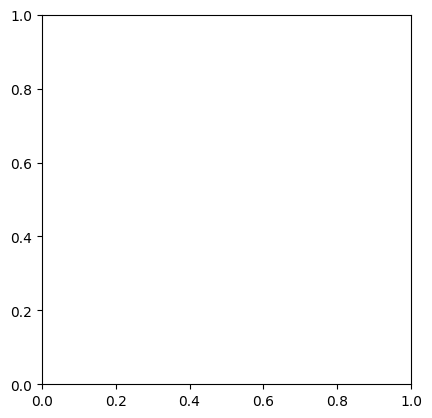

In [6]:
import matplotlib.pyplot as plt
plt.imshow(points_df['image_basename'].iloc[0])

[[[708.0, 424.0], [708.0, 425.0], [707.0, 426.0], [707.0, 427.0], [704.0, 430.0], [704.0, 431.0], [703.0, 432.0], [703.0, 433.0], [702.0, 434.0], [702.0, 441.0], [703.0, 442.0], [703.0, 445.0], [708.0, 450.0], [709.0, 450.0], [710.0, 451.0], [712.0, 451.0], [713.0, 452.0], [719.0, 452.0], [720.0, 451.0], [723.0, 451.0], [726.0, 448.0], [727.0, 448.0], [730.0, 445.0], [730.0, 444.0], [731.0, 443.0], [731.0, 432.0], [730.0, 431.0], [730.0, 429.0], [726.0, 425.0], [725.0, 425.0], [724.0, 424.0], [723.0, 424.0], [722.0, 423.0], [719.0, 423.0], [718.0, 422.0], [713.0, 422.0], [712.0, 423.0], [710.0, 423.0], [709.0, 424.0]], [[687.0, 482.0], [683.0, 486.0], [682.0, 486.0], [674.0, 492.0], [674.0, 493.0], [672.0, 495.0], [672.0, 496.0], [667.0, 501.0], [667.0, 502.0], [664.0, 506.0], [664.0, 507.0], [662.0, 510.0], [662.0, 512.0], [660.0, 515.0], [660.0, 535.0], [661.0, 536.0], [660.0, 537.0], [660.0, 540.0], [661.0, 541.0], [661.0, 550.0], [666.0, 559.0], [666.0, 562.0], [667.0, 563.0], [667

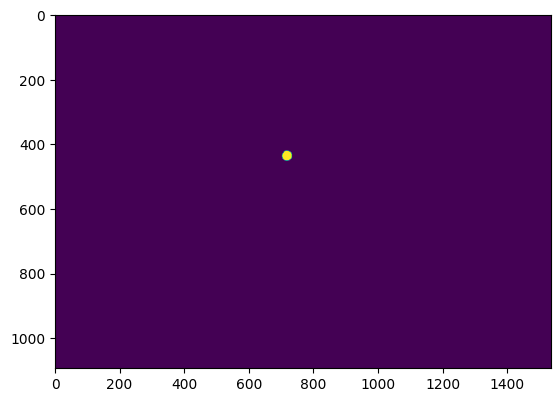

In [8]:
plt.imshow(masks[0])
print(points_list)

In [85]:
# organize_data.print_column_counts(points_df)
# # results_df['image_basename'] = results_df['basename']
# # print('the')
# print(results.columns)
# organize_data.print_column_counts(results)
results_df = pd.merge(results,points_df.reset_index(),on=['image_basename','sample_id'])
results_df.dropna().reset_index(inplace=True,drop=True)
results.shape

(619, 10)

TypeError: object of type 'map' has no len()

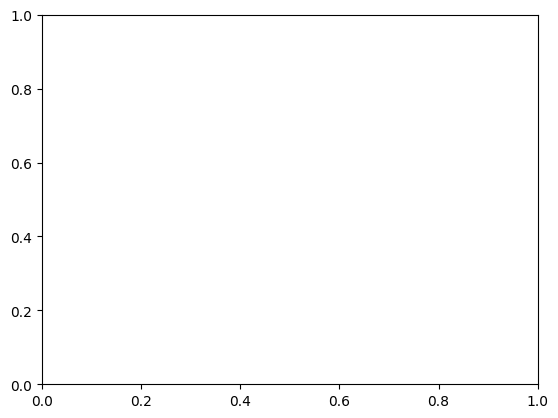

In [ ]:
plt.hist(max_sharpness)

ValueError: setting an array element with a sequence.

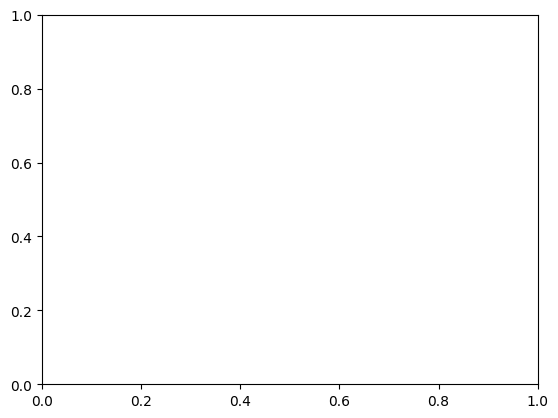

In [ ]:
plt.scatter(portion_of_screen,max_sharpness)

In [ ]:
plt.scatter(results['portion_of_screen'],results['max_sharpness'])

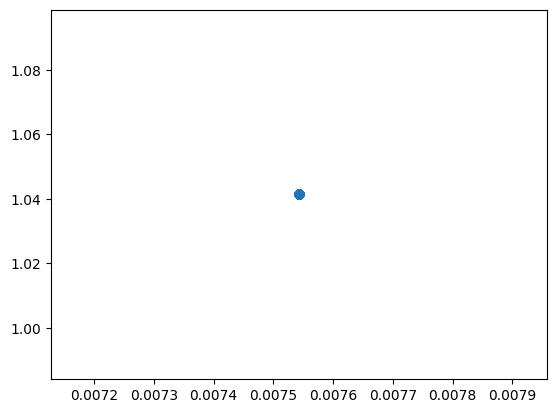

In [66]:
plt.scatter(results['portion_of_screen'],results['aspect_ratio'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

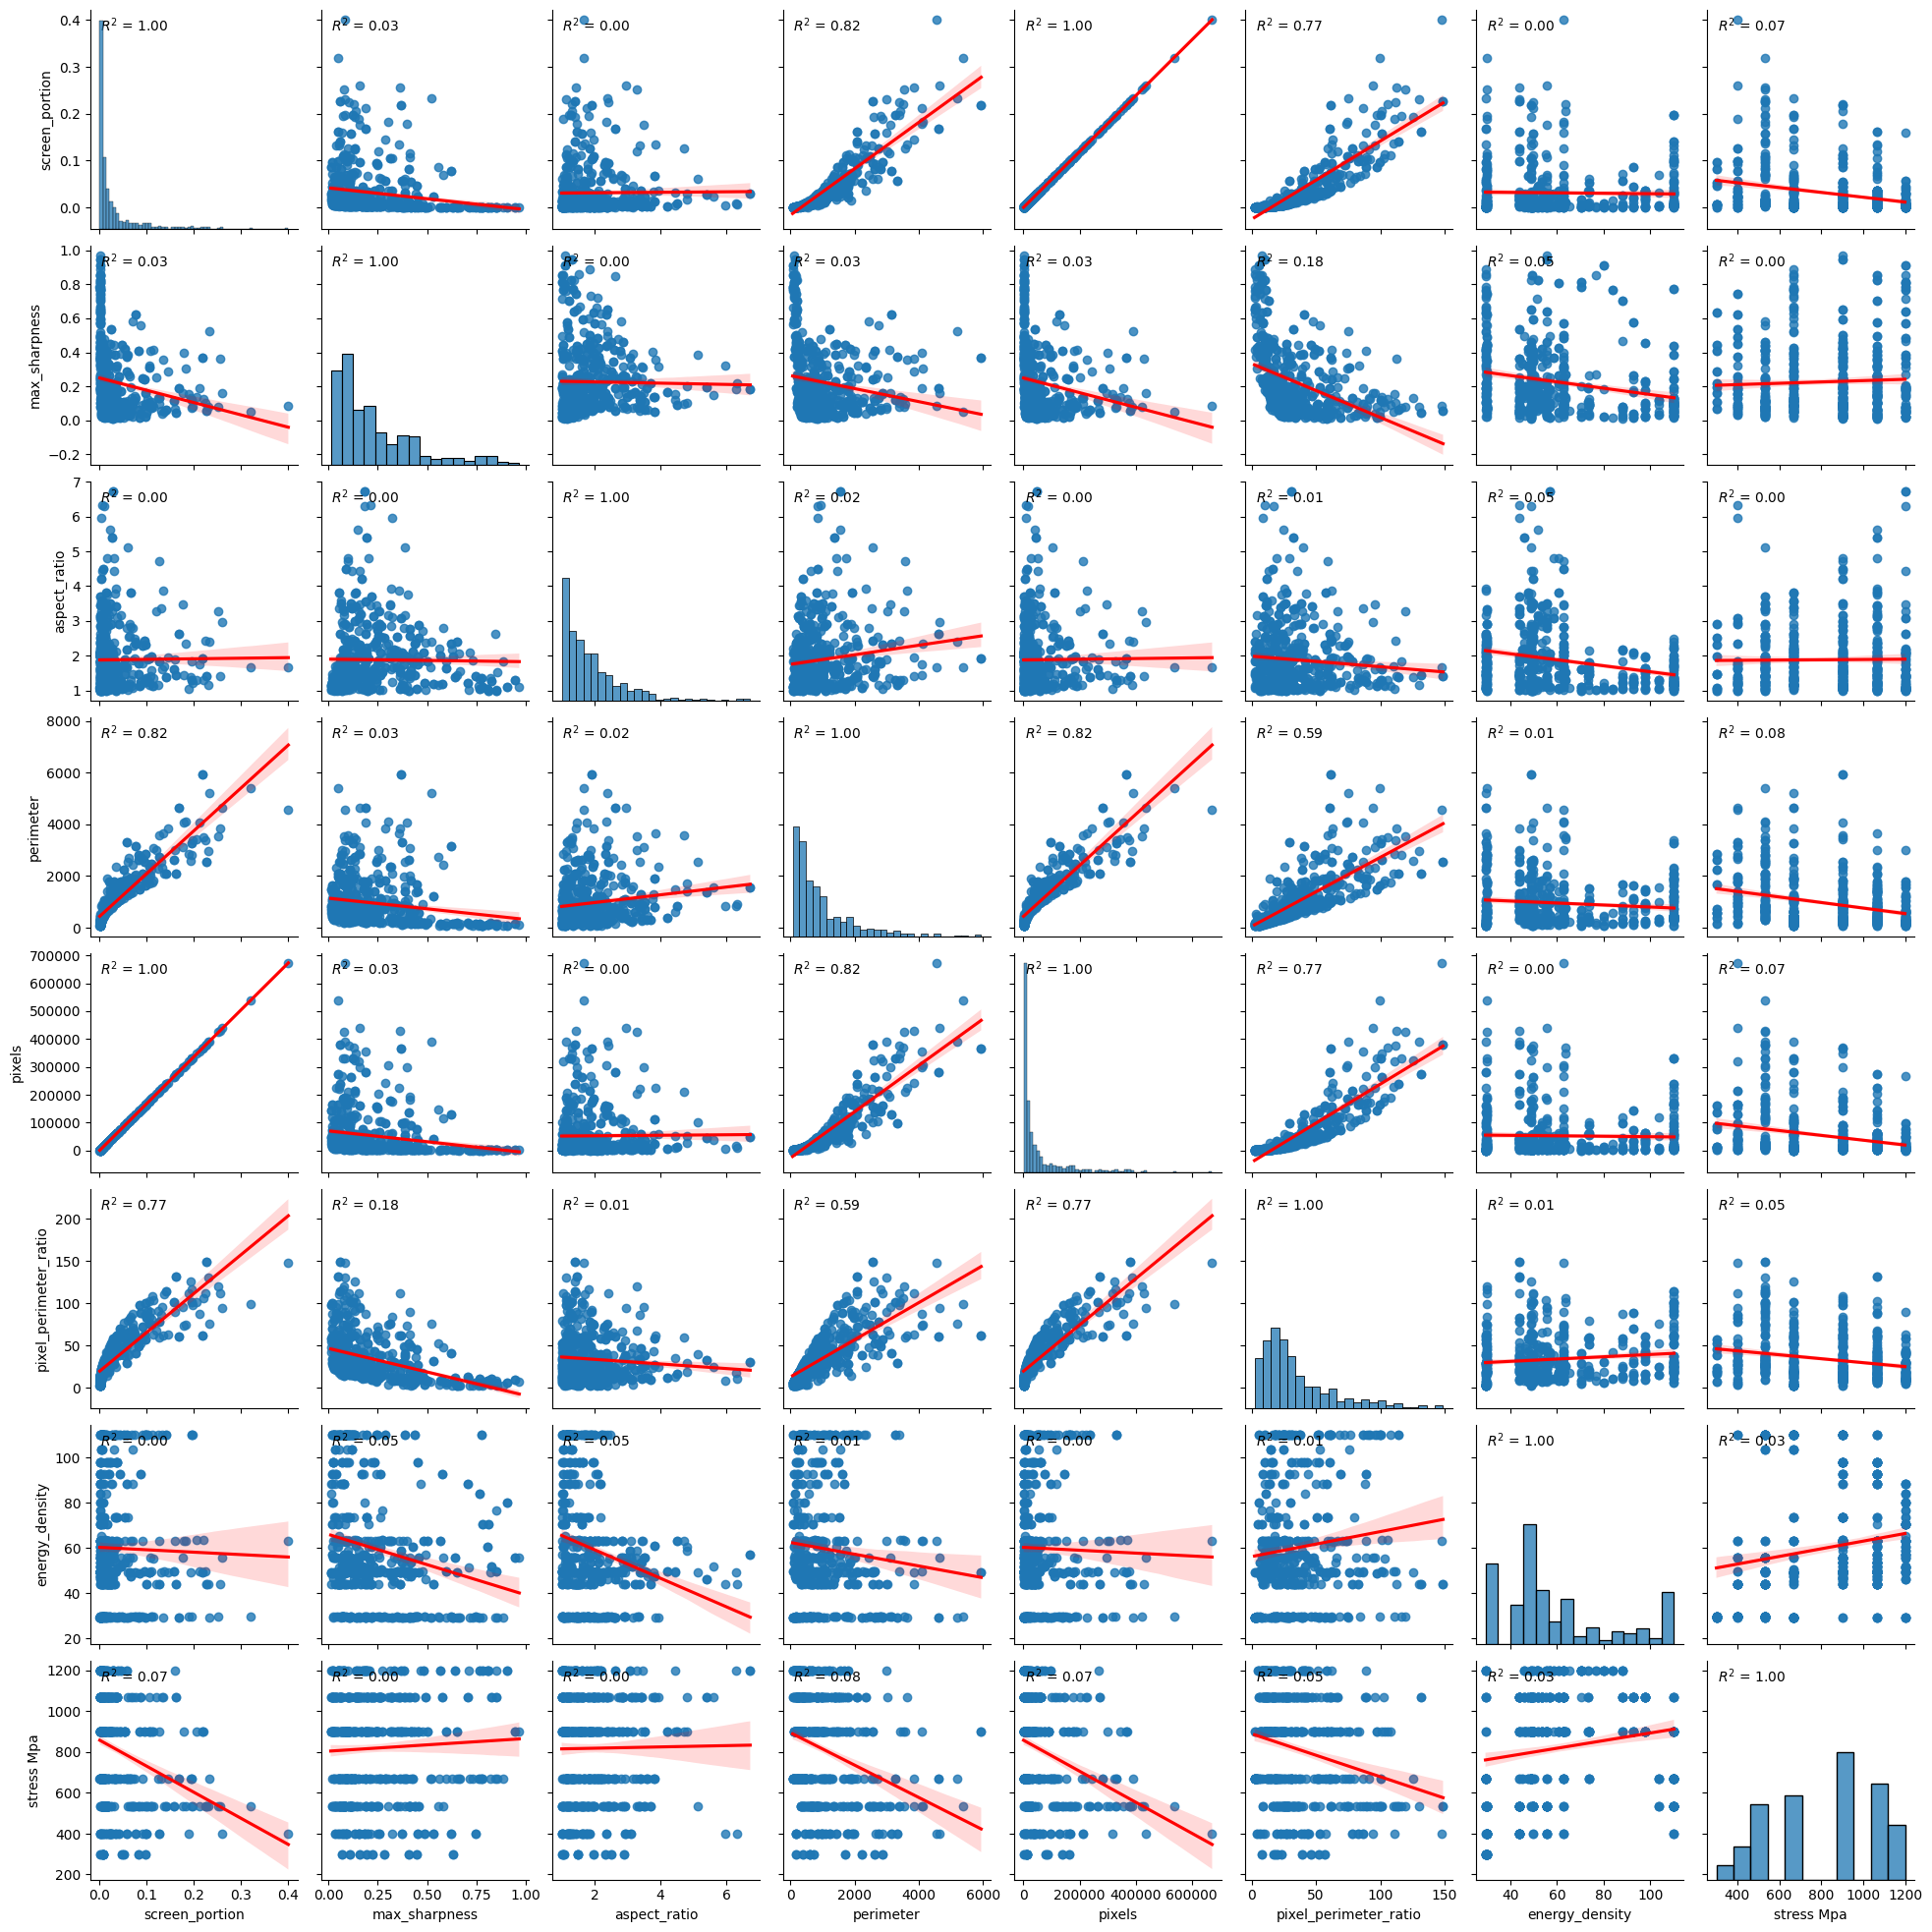

In [21]:
import seaborn as sns
import scipy.stats 
data = {
    "screen_portion": portion_of_screen,
    "max_sharpness": max_sharpness,
    "aspect_ratio": aspect_ratio,
    "perimeter": perimeter,
    "pixels": pixels,
    "pixel_perimeter_ratio": pixel_perimeter_ratio,
    "energy_density":energy,
    "stress Mpa":stress
}
df = pd.DataFrame(data).dropna()


def annotate_r2(x, y, **kwargs):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    r_squared = r_value ** 2
    ax = plt.gca()
    ax.annotate(f"$R^2$ = {r_squared:.2f}", xy=(0.05, 0.9), xycoords=ax.transAxes, fontsize=10)

# Create pairplot with linear regression
g = sns.pairplot(df, kind="reg", plot_kws={"line_kws": {"color": "red"}})

# Add R-squared annotations to each plot
g.map(annotate_r2)
plt.show()